# Описание проекта

Нефтяной компании нужно принять решегие, где бурить новую скважину.

В качестве исходных данных предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

# 1. Загрузка и подготовка данных

#### 1.1. Импорт библиотек

In [73]:
# Импорт используемых в проекте библиотек
import pandas as pd
from numpy.random import RandomState 
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для подготовки признаков
from sklearn.model_selection import train_test_split

# Библиотеки для решения задачи регрессии
from sklearn.linear_model import LinearRegression

# Используемые метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#### 1.2. Описание используемых в проекте глобальных переменных и констант

In [74]:
# Константы используемые в проекте

PRODUCT_PRICE = 450000      # Доход с единицы продукта (с 1 тыс. баррелей) равен 450 тыс. руб.
BUDGET = 10000000000        # Бюджет на разработку скважин в регионе - 10 млрд руб.
WELL_PROFIT_NUM = 200       # Количество лучших скважин для расчёта прибыли
WELL_RESEARCH_NUM = 500     # Количество скважин для исследования

FIGSIZE_1 = (16, 8)    # Размер графиков в атрибуте figsize
RANDOM_STATE=12345       # значение параметра random_state в соответствующих функциях работы с моделью
state = RandomState(RANDOM_STATE)    # Значение параметра random_state в функции bootstrap

#### 1.3. Описание используемых в проекте функций

In [75]:
# Функции используемые в проекте

# Функция для расчёта среднего запаса предсказанного сырья и метрик модели, используется на шаге 2
def step2_fun(df):
    # Разделение данных на две части функцией train_test_split 
    df_train, df_valid = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)
    
    # Подготовка признаков и целевых признаков
    features_train = df_train.drop(['id', 'product'], axis=1)
    target_train = df_train['product']

    features_valid = df_valid.drop(['id', 'product'], axis=1)
    target_valid = df_valid['product']
    
    # Обучение модели и выполнение предсказания на валидационной выборке
    model = LinearRegression().fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # Приведение значений предсказаний и целевого признака к одному типу данных
    target_valid = target_valid.reset_index(drop=True)
    predictions = pd.Series(predictions)
    
    # Вывод метрик на экран
    print('Средний запас предсказанного сырья = {:.3f}'.format(predictions.mean()))
    rmse = mean_squared_error(target_valid, predictions)**0.5
    mae = mean_absolute_error(target_valid, predictions)
    r2 = r2_score(target_valid, predictions)
    print('RMSE модели = {:.3f}'.format(rmse))
    print('MAE модели = {:.3f}'.format(mae))
    print('R2 модели = {:.3f}'.format(r2))
    print()
    return target_valid, predictions   # Фукнция возвращает значения целевого признака и предсказания модели
    

# Функция для расчёта прибыли в выбранном регионе, используется на шаге 4
def revenue(target, predictions, count):
    predictions = predictions.sort_values(ascending=False)[:count]
    max_volume_wells = target.loc[predictions.index]
    income = max_volume_wells.sum() * PRODUCT_PRICE
    profit = income - BUDGET
    return profit    


# Функция с применением техники bootstrap для расчёта средней прибыли региона, 
# 95%-го доверительного интервала и риска убытков. Используется на шаге 4
def bootstrap_fun(target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=WELL_RESEARCH_NUM, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, WELL_PROFIT_NUM))

    values = pd.Series(values)
    confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem())
    mean = values.mean()
    risk = (values < 0).mean()
    
    print('Средняя прибыль = {:.3f} млн руб.'.format(mean / 1000000))
    print('Доверительный интервал = {:.3f} ... {:.3f} млн руб.'.format(
        confidence_interval[0] / 1000000, confidence_interval[1] / 1000000))
    print('Риск убытков = {:.2%}'.format(risk))
    return mean, risk
    
# Функция для отображения основных параметров столбца и построения его гистрограммы и ящика с усами
# https://stackoverflow.com/questions/33381330/histogram-with-boxplot-above-in-python
def histogram_boxplot(data, xlabel = None, title = None, font_scale=1.5, figsize=FIGSIZE_1, bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(data, ax=ax_box2)
    sns.distplot(data, ax=ax_hist2, bins=bins) if bins else sns.distplot(data, ax=ax_hist2)
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

#### 1.4. Открытие исходного файла

In [76]:
# Открытие исходных файлов с данными

# Применение функции pd.read_csv, первый аргумент - путь к файлу, второй аргумент - знак разделителя столбцов
df_geo0 = pd.read_csv('datasets\geo_data_0.csv', sep=',')
df_geo1 = pd.read_csv('datasets\geo_data_1.csv', sep=',')
df_geo2 = pd.read_csv('datasets\geo_data_2.csv', sep=',')

#### 1.5. Изучение исходного файла

In [77]:
# Просмотр исходной таблицы и общей информации о ней

# Вывод на экран первых пяти записей исходных таблиц функцией display() 
display(df_geo0.head())
display(df_geo1.head())
display(df_geo2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [78]:
# Просмотр общей информации методом info()
print(df_geo0.info())
print()
print(df_geo1.info())
print()
print(df_geo2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

#### 1.6. Построение гистограмм и диаграмм размаха по количественным данным

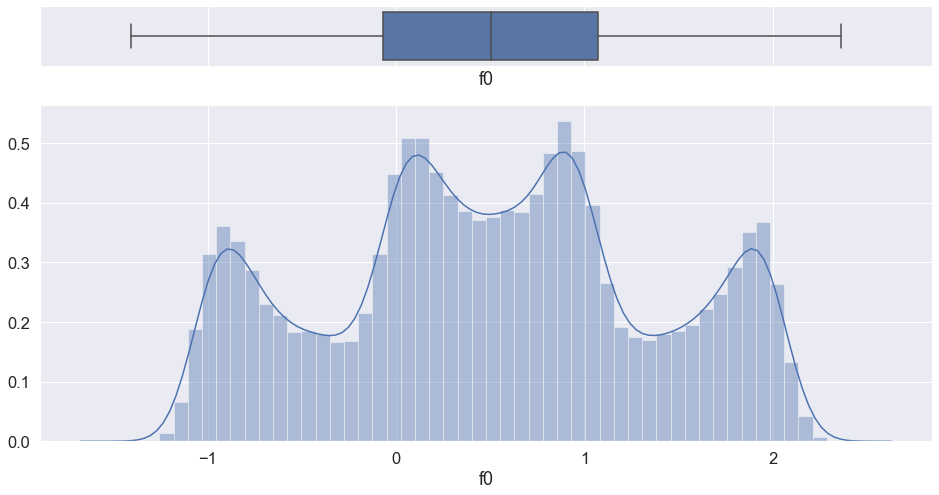

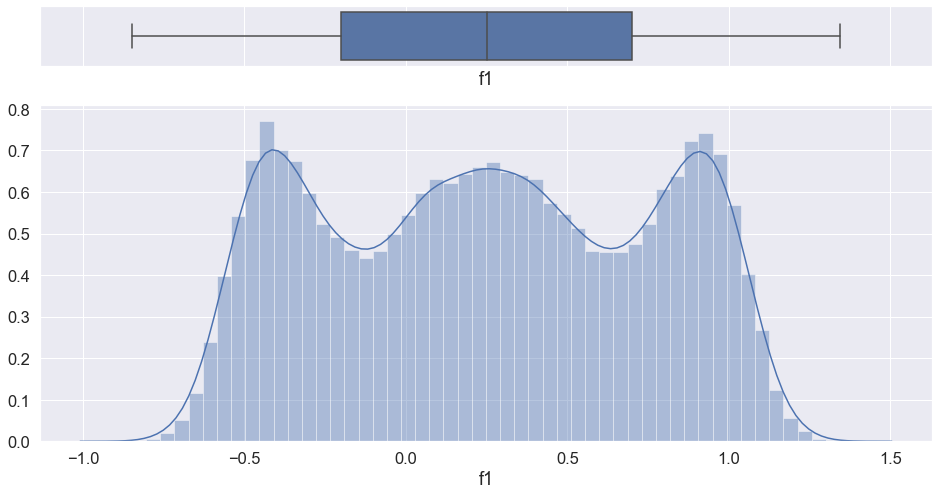

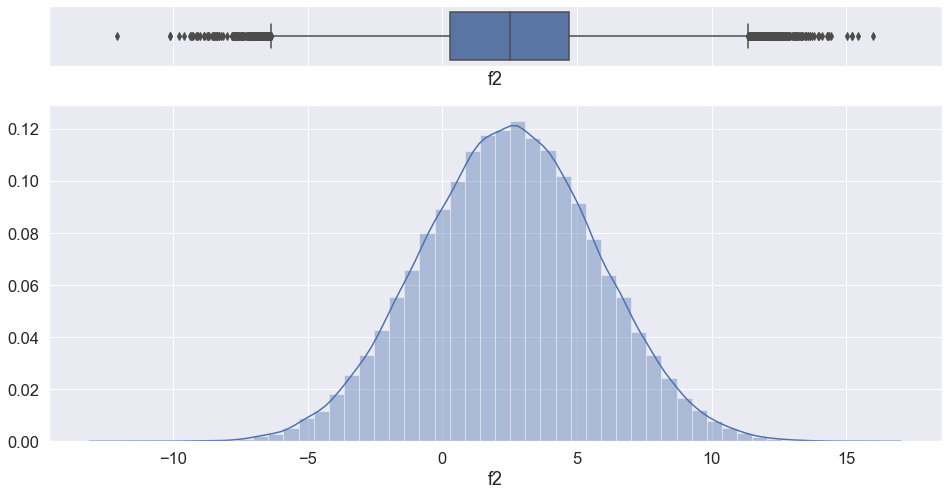

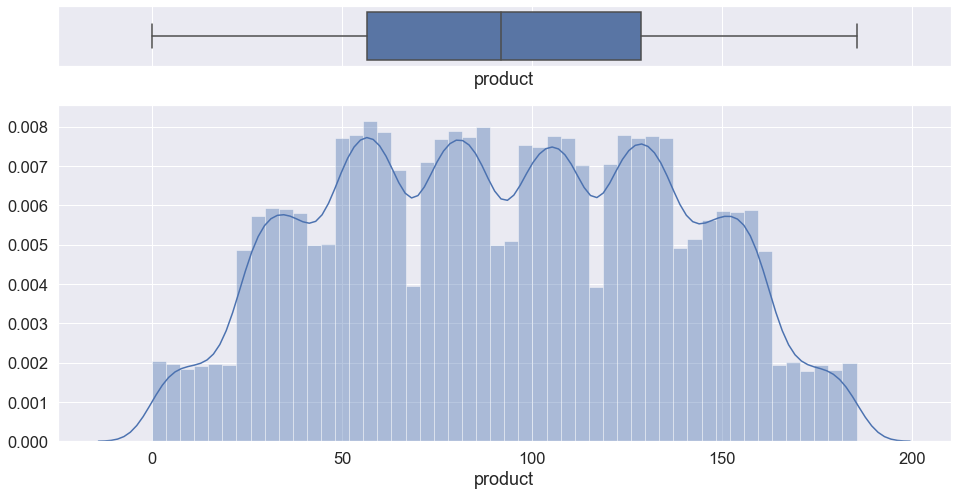

In [79]:
# Таблица geo_data_0
histogram_boxplot(df_geo0['f0'])
histogram_boxplot(df_geo0['f1'])
histogram_boxplot(df_geo0['f2'])
histogram_boxplot(df_geo0['product'])

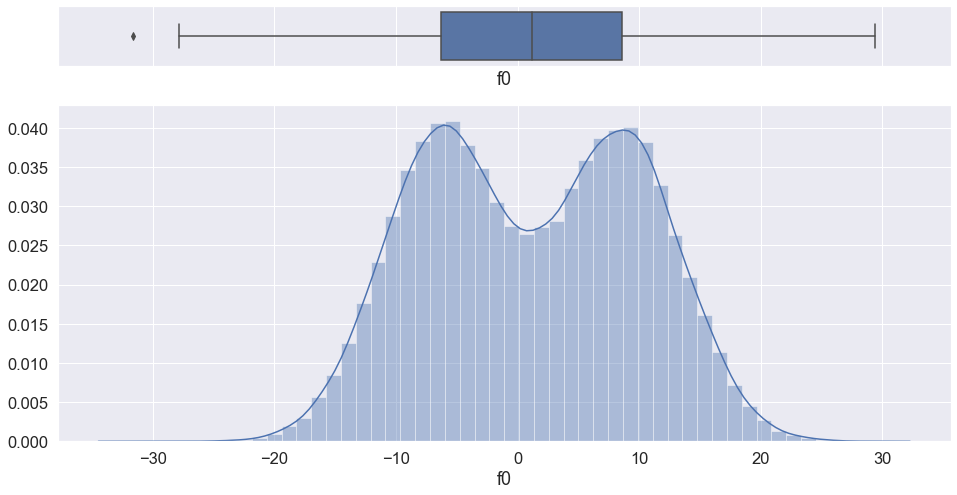

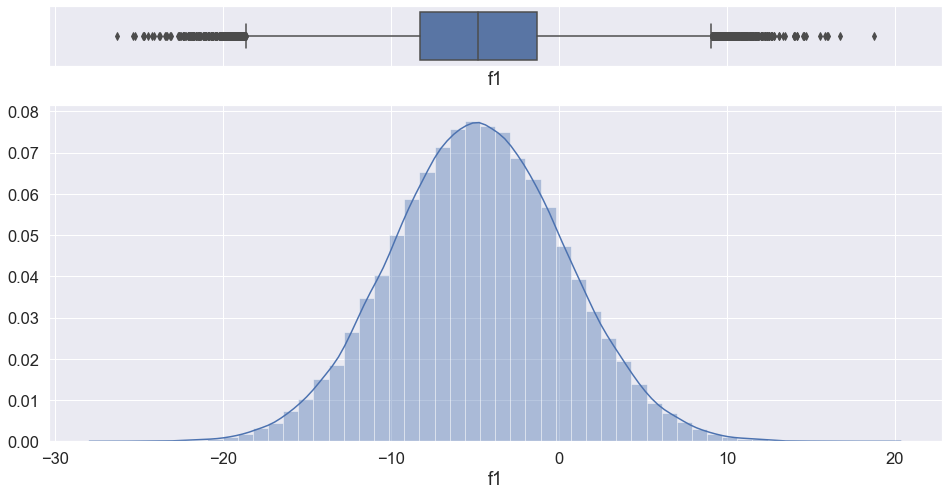

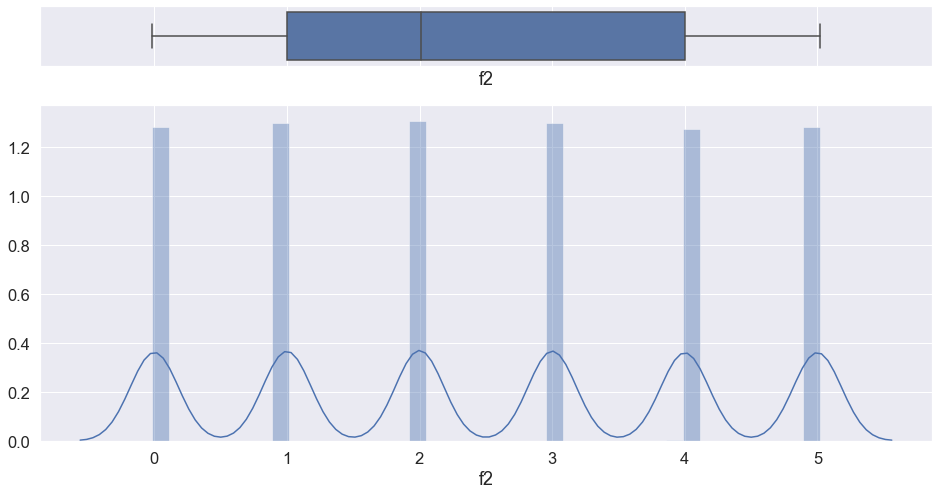

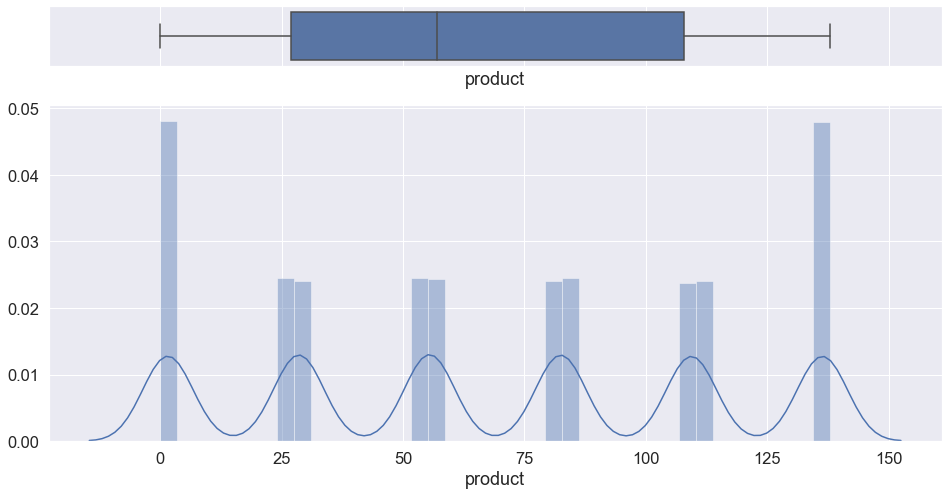

In [80]:
# Таблица geo_data_1
histogram_boxplot(df_geo1['f0'])
histogram_boxplot(df_geo1['f1'])
histogram_boxplot(df_geo1['f2'])
histogram_boxplot(df_geo1['product'])

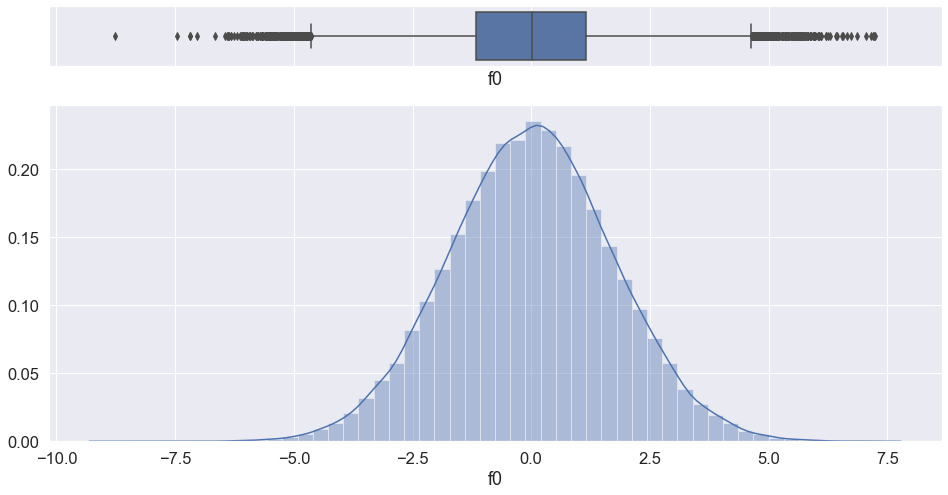

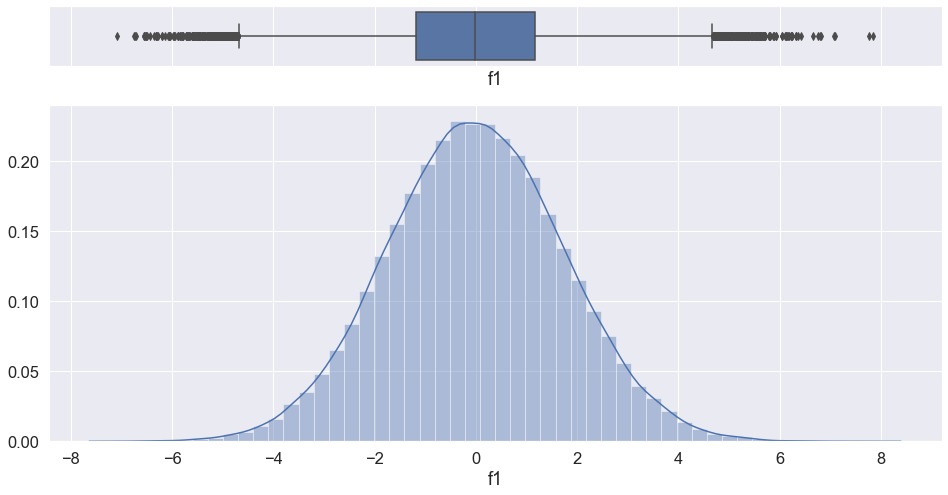

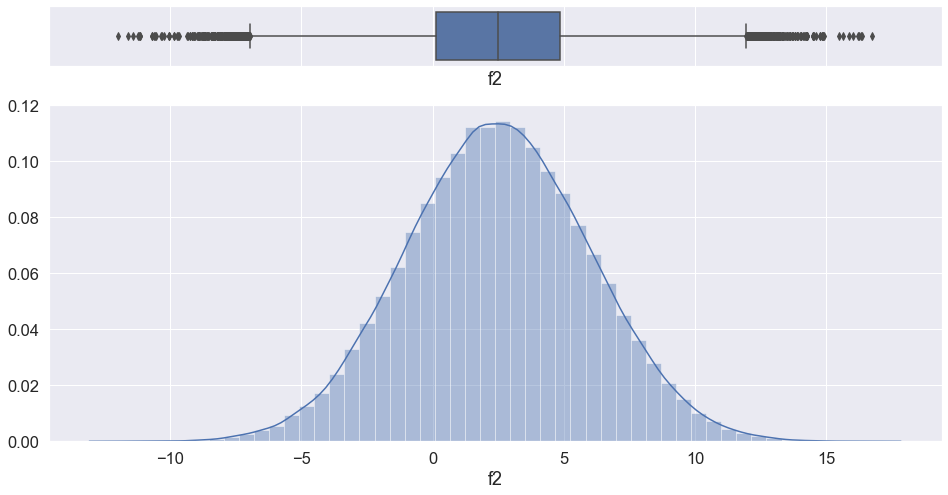

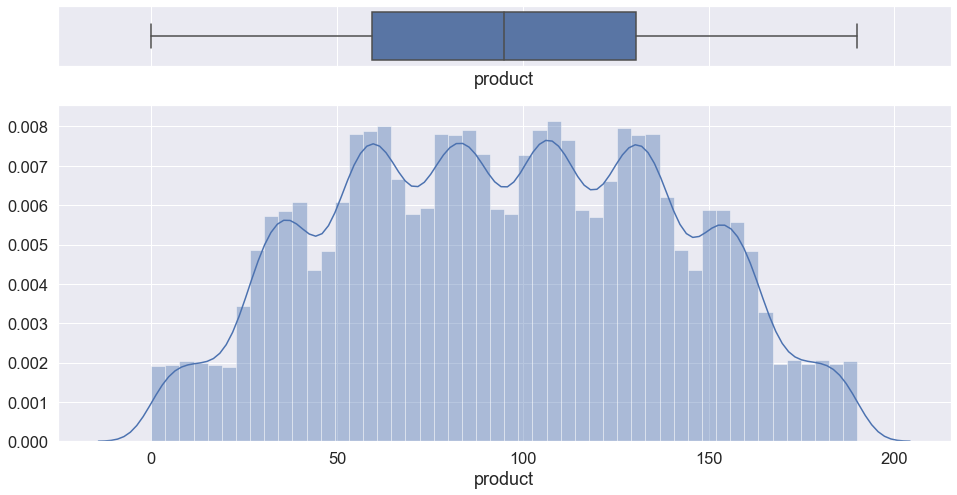

In [81]:
# Таблица geo_data_2
histogram_boxplot(df_geo2['f0'])
histogram_boxplot(df_geo2['f1'])
histogram_boxplot(df_geo2['f2'])
histogram_boxplot(df_geo2['product'])

#### 1.7. Проверка корреляции между столбцами

In [82]:
print('Корреляция столбцов для таблицы geo_data_0:')
display(df_geo0.drop(['id'], axis=1).corr())
print('Корреляция столбцов для таблицы geo_data_1:')
display(df_geo1.drop(['id'], axis=1).corr())
print('Корреляция столбцов для таблицы geo_data_2:')
display(df_geo2.drop(['id'], axis=1).corr())

Корреляция столбцов для таблицы geo_data_0:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Корреляция столбцов для таблицы geo_data_1:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Корреляция столбцов для таблицы geo_data_2:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


#### 1.8. Проверка наличия дубликатов в данных

In [83]:
print(df_geo0.duplicated().sum())
print(df_geo1.duplicated().sum())
print(df_geo2.duplicated().sum())

0
0
0


### Выводы по шагу 1.
1. В исходных данных нет пропусков и дубликатов.
1. Типы данных соответствуют хранимым в них значениям.
1. По графикам видно, что в данных есть распределения отличные от нормального.
1. Расчет корреляции между столбцами показал отсутствие корреляции между признаками. При этом наблюдается сильная положительная корреляция для данных **geo_data_1** между признаком **f2** и целевым признаком **product**, значение равно 0,999.

# 2. Обучение и проверка модели

In [84]:
# Вызов написанной функции для расчета среднего запаса предсказанного сырья и RMSE модели
print('Регион geo_data_0:')
target_valid_geo0, predictictions_geo0 = step2_fun(df_geo0)
print('Регион geo_data_1:')
target_valid_geo1, predictictions_geo1 = step2_fun(df_geo1)
print('Регион geo_data_2:')
target_valid_geo2, predictictions_geo2 = step2_fun(df_geo2)

Регион geo_data_0:
Средний запас предсказанного сырья = 92.593
RMSE модели = 37.579
MAE модели = 30.920
R2 модели = 0.280

Регион geo_data_1:
Средний запас предсказанного сырья = 68.729
RMSE модели = 0.893
MAE модели = 0.719
R2 модели = 1.000

Регион geo_data_2:
Средний запас предсказанного сырья = 94.965
RMSE модели = 40.030
MAE модели = 32.793
R2 модели = 0.205



# 3. Подготовка к расчёту прибыли

Рассчёт достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе

In [85]:
profitable_well_volume = BUDGET / PRODUCT_PRICE / WELL_PROFIT_NUM
print('Достаточный объём сырья для безубыточной разработки новой скважины = {:.1f} тыс. баррелей'.format(profitable_well_volume))

Достаточный объём сырья для безубыточной разработки новой скважины = 111.1 тыс. баррелей


### Выводы по шагу 3.
1. Достаточный объём сырья для безубыточной разработки новой скважины составил 111 тыс. баррелей, это значение больше чем средний запас в каждом регионе.
1. Средний запас рассчитывался по предсказаниям модели на валидационной выборке которая составила 25 тыс. скважин, а среди них много скважин с низким показателем объёма запаса продукта, в то время как в разработку будут задействоваться только 200 скважин с наибольшими значениями объёма продукта. По этой причине средние значения по регионам получились меньше безубыточного объема.

# 4. Расчёт прибыли и рисков 

#### 4.1. Расчёт средней прибыли каждого региона, 95%-го доверительного интервала и риска убытков

In [86]:
# Вызов написанной функции для расчёта средней прибыли, 95%-го доверительного интервала и риска убытков
print('Регион geo_data_0:')
mean_geo0, risk_geo0 = bootstrap_fun(target_valid_geo0, predictictions_geo0)

Регион geo_data_0:
Средняя прибыль = 600.735 млн руб.
Доверительный интервал = 580.991 ... 620.479 млн руб.
Риск убытков = 2.00%


In [87]:
print('Регион geo_data_1:')
mean_geo1, risk_geo1 = bootstrap_fun(target_valid_geo1, predictictions_geo1)

Регион geo_data_1:
Средняя прибыль = 663.959 млн руб.
Доверительный интервал = 648.078 ... 679.840 млн руб.
Риск убытков = 0.10%


In [88]:
print('Регион geo_data_2:')
mean_geo2, risk_geo2 = bootstrap_fun(target_valid_geo2, predictictions_geo2)

Регион geo_data_2:
Средняя прибыль = 597.381 млн руб.
Доверительный интервал = 577.080 ... 617.682 млн руб.
Риск убытков = 2.50%


#### 4.2. Определение региона для разработки исходя из показателей средней прибыли и риска убытков

In [89]:
df_out = pd.DataFrame(data=[['geo_data_0', mean_geo0, risk_geo0], ['geo_data_1', mean_geo1, risk_geo1],
                            ['geo_data_2', mean_geo2, risk_geo2]], columns=['region', 'mean', 'risk'])
df_out = df_out[df_out['risk'] <= 0.025]
df_out_mean_max = df_out['mean'].max()
print('Регион для разработки с риском убытков меньше 2,5% и максимальным значением средней прибыли:')
display(df_out[df_out['mean'] == df_out_mean_max])

Регион для разработки с риском убытков меньше 2,5% и максимальным значением средней прибыли:


,region,mean,risk
1,geo_data_1,6.639590e+08,0.001


### Выводы по шагу 4.
1. По условиям задачи после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них нужно выбрать регион с наибольшей средней прибылью. Таким регионом оказался "geo_data_1".
1. Для региона "geo_data_1" были получены наилучшие значения метрик модели, что также свидетельствует в пользу выбора данного региона.